# Image segmentation   UNet-ResNeXt50 


In [1]:
!pip3 install -r requirements.txt

  Using cached scikit_learn-0.23.2-cp38-cp38-manylinux1_x86_64.whl (6.8 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.1
    Uninstalling scikit-learn-0.23.1:
      Successfully uninstalled scikit-learn-0.23.1


In [7]:
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid import ImageGrid
plt.style.use("dark_background")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import sys
import os
import glob
import random
import time
import numpy as np
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensor, ToTensorV2
from sklearn.model_selection import train_test_split

#custom libraries
from model import UNet, RESNET_UNET

from dataTransformer import DatasetGenerator, dataAugmented, transforms
from train import plot_model_history, compute_iou, TRAINING_MODEL
from metrics import soft_dice_loss
from utils import plot_samples, plot_statistics, random_test_sample, positiv_negativ_diagnosis



## Data preprocessing

In [4]:
# Path to all data
DATA_PATH = "/home/aissatou/Documents/AI4DEV/AI4DEV/Test/"

BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# img size
IMG_SIZE = 512

In [3]:
Data= []
for sub_dir_path in glob.glob(DATA_PATH+"*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            Data.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)
        
        
df = pd.DataFrame({"dirname" : Data[::2],
                  "path" : Data[1::2]})
df.head(10)

,dirname,path
0,doc1,/home/aissatou/Documents/AI4DEV/AI4DEV/Test/do...
1,doc1,/home/aissatou/Documents/AI4DEV/AI4DEV/Test/do...
2,doc1,/home/aissatou/Documents/AI4DEV/AI4DEV/Test/do...
3,doc1,/home/aissatou/Documents/AI4DEV/AI4DEV/Test/do...
4,doc1,/home/aissatou/Documents/AI4DEV/AI4DEV/Test/do...
5,doc1,/home/aissatou/Documents/AI4DEV/AI4DEV/Test/do...
6,doc1,/home/aissatou/Documents/AI4DEV/AI4DEV/Test/do...
7,doc1,/home/aissatou/Documents/AI4DEV/AI4DEV/Test/do...
8,doc1,/home/aissatou/Documents/AI4DEV/AI4DEV/Test/do...
9,doc1,/home/aissatou/Documents/AI4DEV/AI4DEV/Test/do...


In [5]:
# Masks/Not masks
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# Data sorting
imgs  = sorted(df_imgs["path"].values, key=lambda x : (x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : (x[BASE_LEN:-END_MASK_LEN]))

In [8]:
# # General dataframe using masks and images
general_DF = pd.DataFrame({"patient_code": df_imgs.dirname.values,"img_path": imgs,"mask_path": masks})

general_DF["diagnosis_class"] = general_DF["mask_path"].apply(lambda x: positiv_negativ_diagnosis(x))

In [9]:
#Negative data
Negative_data = general_DF.loc[general_DF['diagnosis_class' ]== 0]
#Positive data
Positive_data = general_DF.loc[general_DF['diagnosis_class'] == 1]

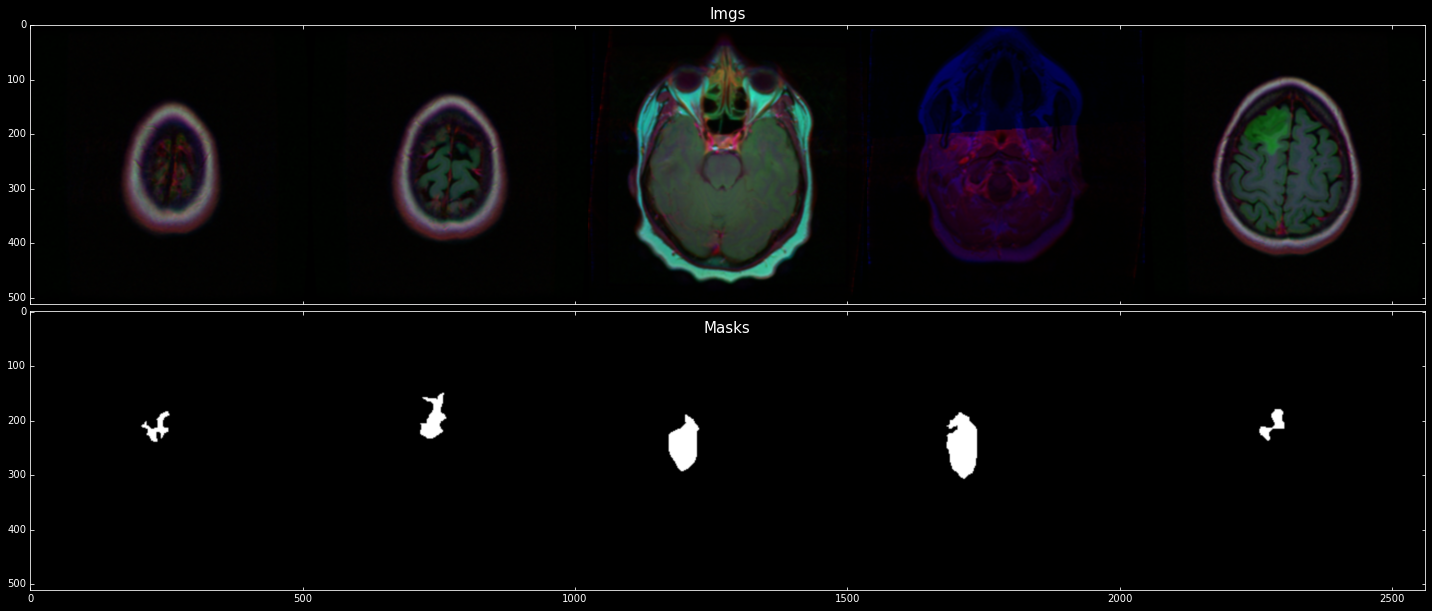

In [10]:
#DATA SIMPLES
Plot_samples_df = general_DF[general_DF["diagnosis_class"] == 1].sample(5).values
plot_samples(Plot_samples_df, IMG_SIZE)


##  Statistic data distribution 

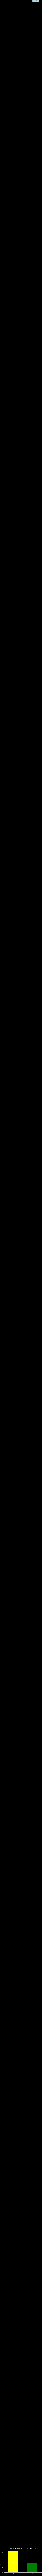

In [11]:
from utils import plot_statistics
plot_statistics(general_DF)

 Ploting data 

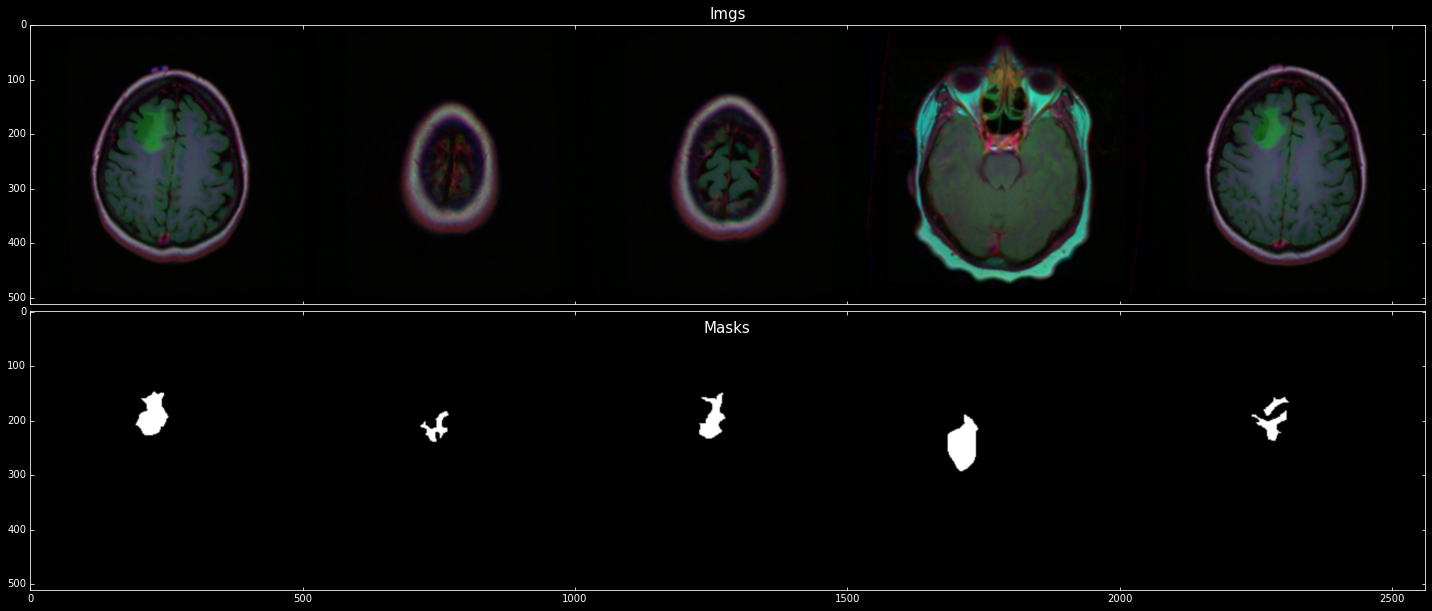

In [12]:
# DATA SIMPLES
Plot_samples_df = general_DF[general_DF["diagnosis_class"] == 1].sample(5).values
plot_samples(Plot_samples_df, IMG_SIZE)


# Data transformation 

In [13]:
from dataTransformer import transforms


Split data on train val test

In [14]:
# Split df into train_df and val_df
train_df, val_df = train_test_split(general_DF, stratify=general_DF.diagnosis_class, test_size=0.15)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Split train_df into train_df and test_df
train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis_class, test_size=0.1)
train_df = train_df.reset_index(drop=True)

#train_df = train_df[:1000]
print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (22, 4) 
Val: (5, 4) 
Test: (3, 4)


In [15]:
from dataTransformer import DatasetGenerator
# train
train_dataset = DatasetGenerator(general_DF=train_df, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=1, num_workers=4, shuffle=True)

# val
val_dataset = DatasetGenerator(general_DF=val_df, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=1, num_workers=4, shuffle=True)

#test
test_dataset = DatasetGenerator(general_DF=test_df, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=4, shuffle=True)

Augmentation Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
torch.Size([1, 3, 128, 128]) torch.Size([1, 1, 128, 128])


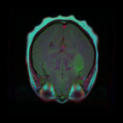

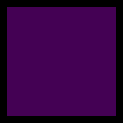

In [16]:
from dataTransformer import dataAugmented
    
images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

dataAugmented(images)
dataAugmented(masks, image=False)

## MODEL CODING

Unet Model coding

In [17]:
from model import UNet, RESNET_UNET
from torchvision.models import resnext50_32x4d
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



In [18]:
unet = UNet(n_classes=1).to(device)
output = unet(torch.randn(1,3,256,256).to(device))
print("",output.shape)

 torch.Size([1, 1, 256, 256])


## Unet_plus_ResNeXt50 Model Combunation

In [19]:

RESTNET_UNET_MODEL = RESNET_UNET(n_classes=1).to(device)
output = RESTNET_UNET_MODEL(torch.randn(1,3,256,256).to(device))
print(output.shape)

torch.Size([1, 1, 256, 256])


# -----Model Training -------

In [20]:
from metrics import soft_dice_loss
from train import plot_model_history, TRAINING_MODEL

In [21]:
%%time
num_ep = 2                                                                                   # Optimizers
optimizer = torch.optim.Adam(RESTNET_UNET_MODEL.parameters(), lr=5e-4)
             
# Train RESTNET_UNET_MODEL
RESTNET_UNET_MODEL_lh, RESTNET_UNET_MODEL_th, RESTNET_UNET_MODEL_vh = TRAINING_MODEL("RESTNET_UNET_MODEL", RESTNET_UNET_MODEL, train_dataloader, val_dataloader, soft_dice_loss, optimizer, False, num_ep)

Epoch [0]
soft_dice_Loss : 0.9907975684512745 
 IoU on train: 0.5007457451122703 
 IoU on validation: 0.7500000000019563
Epoch [1]
soft_dice_Loss : 0.9771159209988334 
 IoU on train: 0.7272727272754722 
 IoU on validation: 0.7500000000018708
CPU times: user 5min 4s, sys: 4.99 s, total: 5min 9s
Wall time: 1min 19s


RESTNET_UNET_MODEL
 Decie Coeff of the test images - 2.0


## Train history 

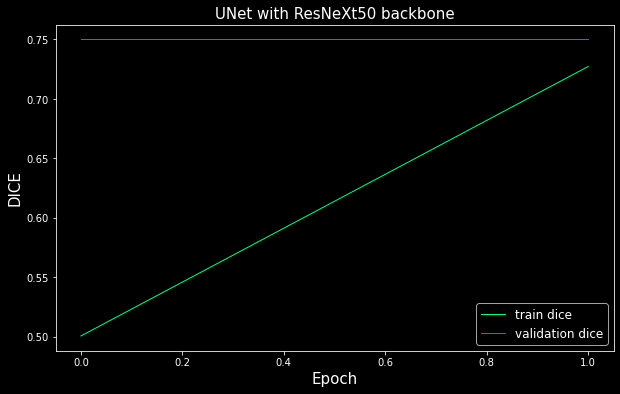

In [22]:
#plot_model_history
plot_model_history("UNet with ResNeXt50 backbone", RESTNET_UNET_MODEL_th, RESTNET_UNET_MODEL_vh, num_ep)

# Test Prediction

### Test IoU

In [23]:
#Test iou
from train import compute_iou
test_iou = compute_iou(RESTNET_UNET_MODEL, test_dataloader)
print(f"""RESTNET_UNET_MODEL\n Decie Coeff of the test images - {np.around(test_iou, 2)}""")


RESTNET_UNET_MODEL
 Decie Coeff of the test images - 1.0


### random test sample

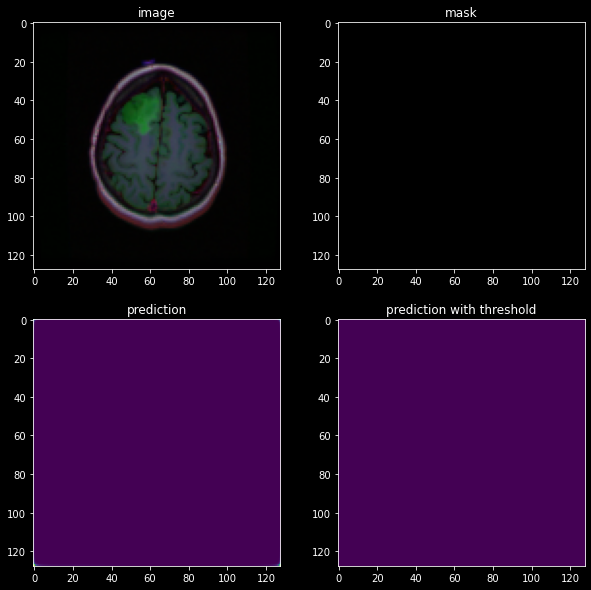

In [24]:
# image
test_sample = test_df[test_df["diagnosis_class"] == 0].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

#mask
mask = cv2.resize(cv2.imread(test_sample[2]), (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = RESTNET_UNET_MODEL(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

# pred with tshd
pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.8)] = 0.0
pred_t[np.nonzero(pred_t >= 0.8)] = 255.#1.0
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")

plt.show()